# Explore Data and Look for Outliers

In [1]:
# Imports
import math
import numpy as np
import pandas as pd
from scipy.stats import shapiro 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

## Missing data

In [3]:
# Read merged dataFrame
file='DataPatientsWithGT.csv'
df = pd.read_csv(file,sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

In [4]:
# print(df.shape)
df.head(1)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1-Vumc-HD-101-TR922,3.9378,1.555228,7.445603,13.655275,11.121538,3.471206,5.986674,4.978068,46.477912,25.632179,...,Vumc-HD-101-TR922,NaN,F,35.0,Institute 13,1,0,0,nonMalignant,Asymptomatic controls


In [5]:
# Missing data
list_na_columns = df.columns[df.isna().any()].tolist()
print("Columns with Nans", list_na_columns)

Columns with Nans ['Stage', 'Sex', 'Age']


In [6]:
print("Number of Nans in Stage: ", df['Stage'].isna().sum()) # 723 non-malig + 256 malig
print("Number of Nans in Sex: ", df['Sex'].isna().sum())
print("Number of Nans in Age: ", df['Age'].isna().sum())

Number of Nans in Stage:  979
Number of Nans in Sex:  20
Number of Nans in Age:  23


## Check for Outliers


We will remove those patients that do not belong to their group. The outliers analysis has to be done with all characteristics (all genes).

We will focus on Class_group: Malignant versus nonMalignant

In [7]:
# Remove columns that are repeated or irrelevant
df_class= df.drop(['Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution', 'Training series', 'Evaluation series', 'Validation series', 'Patient_group'], axis=1, inplace=False)

### Check data Distribution

In [8]:
# Check data distribution
# If data is normally distributed (in more general sense, symmetrically distributed), then the result with PCA is more robust.
# Otherwise, It is better to use t-SNE
columns = df_class.columns
Patient_mean = df_class[columns[0:-1]].mean(axis=0)
Patient_mean.describe()


count     5251.000000
mean       190.439916
std       1769.654240
min          1.617180
25%         11.553920
50%         24.861129
75%         68.791953
max      84557.263507
dtype: float64

In [9]:
Patient_mean.head(5)

ENSG00000000419    33.676838
ENSG00000000460     4.758876
ENSG00000000938    88.086458
ENSG00000001036    19.834605
ENSG00000001461     8.232891
dtype: float64

In [10]:
# Look for genes to check distribution on
print("Gene with low mean: ", Patient_mean.loc[Patient_mean<11].index[0])
# Patient_mean['ENSG00000000460']   # 4.6

print("Gene with medium mean: ", Patient_mean[Patient_mean.between(11,67)].index[0])
# Patient_mean['ENSG00000000419']   # 32.6


print("Gene with high mean: ", Patient_mean.loc[Patient_mean>67].index[0])
# Patient_mean['ENSG00000000938']   # 85

Gene with low mean:  ENSG00000000460
Gene with medium mean:  ENSG00000000419
Gene with high mean:  ENSG00000000938


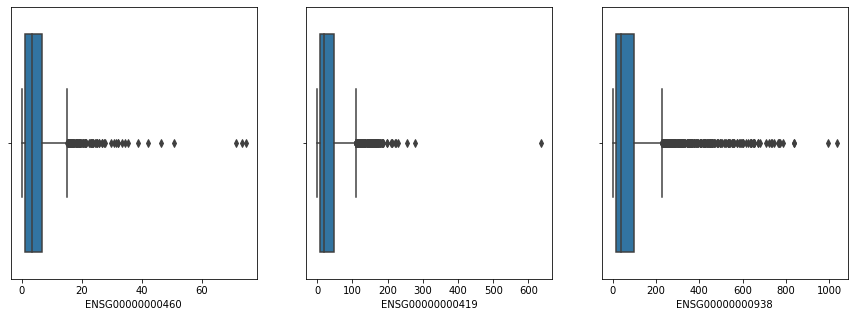

In [11]:
# Represent the genes distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x=df['ENSG00000000460'], ax=ax[0])
sns.boxplot(x=df['ENSG00000000419'], ax=ax[1])
sns.boxplot(x=df['ENSG00000000938'], ax=ax[2])
plt.show()

They are clearly not simetrical and not following a normal distribution.

We can also perform a Shapiro-Wilk Test. If the p-value of the test is greater than α = .05, then the data is assumed to be normally distributed.


In [12]:
np.random.seed(42)
shapiro(df['ENSG00000000460'])

ShapiroResult(statistic=0.7125440239906311, pvalue=0.0)

Since the p-value is less than .05, we reject the null hypothesis of the Shapiro-Wilk test.

This means we have sufficient evidence to say that the sample data does not come from a normal distribution.

In [13]:
shapiro(df['ENSG00000000419'])

ShapiroResult(statistic=0.7549484372138977, pvalue=0.0)

In [14]:
shapiro(df['ENSG00000000938'])

ShapiroResult(statistic=0.6500592827796936, pvalue=0.0)

Same for the other two genes tested.

### Apply tSNE to look for abnormalities (Malignant vs. nonMalignant)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2351 samples in 0.096s...
[t-SNE] Computed neighbors for 2351 samples in 1.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2351
[t-SNE] Computed conditional probabilities for sample 2000 / 2351
[t-SNE] Computed conditional probabilities for sample 2351 / 2351
[t-SNE] Mean sigma: 11889.659432
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.156136
[t-SNE] KL divergence after 4000 iterations: 1.355329


[Text(0.5, 1.0, 'tSNE')]

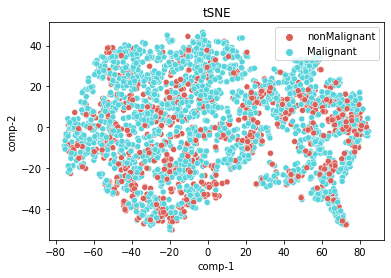

In [15]:
X = df_class[columns[0:-1]]
y = df_class[columns[-1]]

tsne = TSNE(n_components=2, verbose=1, random_state=42, learning_rate='auto', init='random', n_iter=4000)
z = tsne.fit_transform(X)

df_z = pd.DataFrame()
df_z["y"] = y
df_z["comp-1"] = z[:,0]
df_z["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_z.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_z).set(title="tSNE") 

### Apply PCA to look for abnormalities (although we know data does not follow a normal distribution)


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

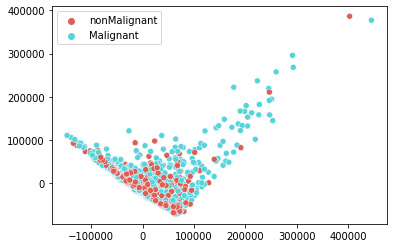

In [16]:
X = df_class[columns[0:-1]]
y = df_class[columns[-1]]

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(X)

sns.scatterplot(z[:, 0], z[:, 1], hue=y.tolist(), palette=sns.color_palette("hls", 2))

In [17]:
# Find potential outliers
threshold = 350000
index_outliers = [i for i,v in enumerate(z) if v[0] > threshold]
print(index_outliers)

print(y.iloc[[index_outliers[0]]])
print(y.iloc[[index_outliers[1]]])

[1671, 2100]
2591-Pang-NSCLC-U5588-T0-TR2706    Malignant
Name: Class_group, dtype: object
3248-Vumc-P-PH-001-012-TR1506    nonMalignant
Name: Class_group, dtype: object


### Apply robust PCA (rPCA) to look for abnormalities

In [18]:
# Download and import robust PCA from https://github.com/dganguli/robust-pca
# https://stackoverflow.com/questions/40721260/how-to-use-robust-pca-output-as-principal-component-eigenvectors-from-traditio
from robust_pca_master.r_pca import R_pca

The robust-pca code factors the data matrix X into two matrices, L and S which are "low-rank" and "sparse" matrices. 
* L is what's mostly constant between the various observations, while 
* S is what varies. 

If you just want the eigenvectors, treat the S as junk (the "large outliers" you're wanting to clip out) and do an eigenanalysis on the L matrix.

iteration: 1, error: 1990.1703331225135
iteration: 100, error: 27.632392129359168
iteration: 200, error: 14.403322429847606
iteration: 300, error: 9.669024189674305
iteration: 400, error: 7.469148062011375
iteration: 500, error: 5.767473803388637
iteration: 600, error: 4.611243056326205
iteration: 700, error: 3.9233229472552034
iteration: 800, error: 3.420352840955757
iteration: 900, error: 3.0051897710581397
iteration: 1000, error: 2.4530234289544692


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

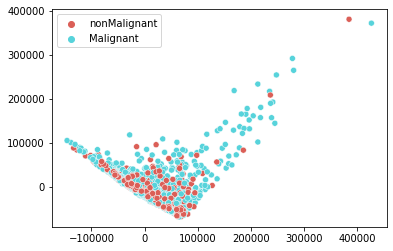

In [19]:
X = df_class[columns[0:-1]]
y = df_class[columns[-1]]

L, S = R_pca(X).fit()

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(L)

sns.scatterplot(z[:, 0], z[:, 1], hue=y.tolist(), palette=sns.color_palette("hls", 2))

In [20]:
# Find potential outliers
threshold = 350000
index_outliers = [i for i,v in enumerate(z) if v[0] > threshold]
print(index_outliers)

print(y.iloc[[index_outliers[0]]])
print(y.iloc[[index_outliers[1]]])

[1671, 2100]
2591-Pang-NSCLC-U5588-T0-TR2706    Malignant
Name: Class_group, dtype: object
3248-Vumc-P-PH-001-012-TR1506    nonMalignant
Name: Class_group, dtype: object


### Apply Multivariate outlier detection with PyOD

Idea from https://towardsdatascience.com/how-to-perform-multivariate-outlier-detection-in-python-pyod-for-machine-learning-b0a9c557a21c

PyOD is the most comprehensive and scalable Python library for detecting outlying objects in multivariate data. 

Isolation Forest: works on almost any type of dataset but is specifically designed for high-dimensional, complex ones. Even though it is a collection of different type of decision trees, called ITrees, it is fast and has a high performance. It can also handle data with irregular, non-normal distributions.

Local Outlier Factor: particularly good for datasets with data points that are clustered together as it calculates anomaly scores using local density. It works well with high-dimensional data and can be faster than IForest

@article{zhao2019pyod,
    author  = {Zhao, Yue and Nasrullah, Zain and Li, Zheng},
    title   = {PyOD: A Python Toolbox for Scalable Outlier Detection},
    journal = {Journal of Machine Learning Research},
    year    = {2019},
    volume  = {20},
    number  = {96},
    pages   = {1-7},
    url     = {http://jmlr.org/papers/v20/19-011.html}
}

In [21]:
X = df_class[columns[0:-1]]
y = df_class[columns[-1]]

# pip install pyod
# from pyod.models.lof import LOF
from pyod.models.iforest import IForest

# predict_proba returns two columns for each sample:
#     the first column is the probability of the sample being an inlier and 
#     the second is the probability of the sample being an outlier. 

iforest = IForest(n_estimators=500).fit(X)
probs = iforest.predict_proba(X)

# We can select samples that have at least 80%, 90%, or n% outlier probability.
# Set a confidence threshold to choose outliers based on probability confidence
# If you are dealing with sensitive data like medical records where it is critical to avoid false positives, 
# you should aim for over 90%. 95% and 99% are pretty common as well.
threshold = 0.9

# Create a mask that returns True if probs over threshold
is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

# Count up the outliers
num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")


c:\Users\acard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


The number of outliers: 2
Percentage of outliers: 0.0009


In [22]:
outliers_X_probs

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000257267,ENSG00000257923,ENSG00000258890,ENSG00000261253,ENSG00000263563,ENSG00000264538,ENSG00000265148,ENSG00000266714,ENSG00000267243,ENSG00000271043
128-Vumc-HD-99-TR1094,111.196291,10.456379,736.292946,57.984968,21.809161,32.673503,13.104864,32.274078,18.381672,298.370612,...,24.439540,55.899163,72.535089,179.504781,3.901433,18.244202,15.322183,36.306098,27.42784,10.978189
356-TR3295-HD-NKI,115.830386,0.000000,1034.225139,102.179182,6.058148,54.456270,15.016108,13.945700,17.871211,266.327887,...,6.480232,53.139131,60.824175,13.777888,45.517081,10.642535,22.345027,41.475003,7.99985,8.004993


In [23]:
np.argwhere(is_outlier == True)


array([[126],
       [313]], dtype=int64)

In [24]:
X = df_class[columns[0:-1]]
y = df_class[columns[-1]]

# pip install pyod
from pyod.models.lof import LOF
# from pyod.models.iforest import IForest

# predict_proba returns two columns for each sample:
#     the first column is the probability of the sample being an inlier and 
#     the second is the probability of the sample being an outlier. 

from pyod.models.iforest import IForest

lof = LOF(n_neighbors=30).fit(X)
probs = lof.predict_proba(X)

# We can select samples that have at least 80%, 90%, or n% outlier probability.
# Set a confidence threshold to choose outliers based on probability confidence
# If you are dealing with sensitive data like medical records where it is critical to avoid false positives, 
# you should aim for over 90%. 95% and 99% are pretty common as well.
threshold = 0.9

# Create a mask that returns True if probs over threshold
is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

# Count up the outliers
num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 3
Percentage of outliers: 0.0013


In [25]:
outliers_X_probs

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000257267,ENSG00000257923,ENSG00000258890,ENSG00000261253,ENSG00000263563,ENSG00000264538,ENSG00000265148,ENSG00000266714,ENSG00000267243,ENSG00000271043
59-Vumc-HD-121-TR1113,9.068572,0.746170,10.716800,0.000000,0.592879,0.000000,1.068762,1.364793,10.493773,1.468401,...,117.324508,3.072993,0.00000,21.573921,6.681779,16.664471,20.410052,0.345442,0.00000,839.812186
3089-Pisa-exIPMN-2015TAG-TR971,53.253557,3.755786,182.803853,6.942466,1.492105,10.059317,0.000000,3.434786,8.803256,62.824140,...,30.325190,29.150580,13.02680,27.147634,22.421453,5.242452,33.021096,13.910024,2.62712,15.772854
3095-Pisa-PDAC-2015PRO-TR966,118.813764,0.318786,52.907495,5.892670,0.000000,2.846070,2.967944,4.081559,34.371581,31.367217,...,17.611309,2.221786,3.53823,10.369143,22.837226,15.129052,8.719777,0.442749,0.00000,192.784063


In [26]:
np.argwhere(is_outlier == True)

array([[  57],
       [1963],
       [1967]], dtype=int64)

### Apply DBSCAN to look for abnormalities (Malignant vs. nonMalignant)

Intenta ajustar el algoritmo DBSCAN para minimizar las diferencias entre ground truth y los clústeres arrojados por el algoritmo. El propio algoritmo DBSCAN, si se ajusta correctamente, sirve también para detectar outliers.

In [27]:
# Read merged dataFrame
file='DataPatientsWithGT.csv'
df = pd.read_csv(file,sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})
# Remove columns that are repeated or irrelevant
df_group= df.drop(['Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution', 'Training series', 'Evaluation series', 'Validation series', 'Patient_group'], axis=1, inplace=False)
columns = df_group.columns
X = df_group[columns[0:-1]]
y = df_group[columns[-1]]

In [28]:
# Apply DBSCAN
# Cluster labels. Noisy samples are given the label -1.
# Find eps and min_samples to obtain 2 groups
dbscan = DBSCAN(eps=70000, min_samples=5)
clusters = dbscan.fit_predict(X)
unique, counts = np.unique(clusters, return_counts=True)
print("Clusters: ", unique)
print("Elements per cluster: ", counts)

Clusters:  [-1  0]
Elements per cluster:  [   8 2343]


In [29]:
np.argwhere(clusters == -1)

array([[  57],
       [ 812],
       [ 819],
       [1671],
       [1961],
       [1963],
       [1967],
       [2100]], dtype=int64)

In [30]:
#DBSCAN performance:
# A mayor ARI, mejor
# print("ARI =", adjusted_rand_score(y, clusters))

### Put all information together

In [2]:
index_outliers_PCA = [1671, 2100]
index_outliers_rPCA = [1671, 2100]
index_outliers_IF_flat = [126, 313]
index_outliers_LOF_flat = [57, 1963, 1967]
index_outliers_DBSCAN = [57,812, 819, 1671, 1961, 1963, 1967, 2100]

In [3]:
# Criteria: remove those outliers that appear at least in 2 lists (without DBSCAN)
index_outliers_total = index_outliers_PCA + index_outliers_rPCA + index_outliers_IF_flat + index_outliers_LOF_flat
index_outliers_repeated = list(set([i for i in index_outliers_total if index_outliers_total.count(i)>1]))
print(index_outliers_repeated)

[2100, 1671]


In [4]:
# Criteria: remove those outliers that appear at least in 2 lists (with DBSCAN)
index_outliers_total = index_outliers_PCA + index_outliers_rPCA + index_outliers_IF_flat + index_outliers_LOF_flat + index_outliers_DBSCAN
index_outliers_repeated = list(set([i for i in index_outliers_total if index_outliers_total.count(i)>1]))
print(index_outliers_repeated)

[1671, 1963, 1967, 2100, 57]
